In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import collections.abc

# Backward compatibility for causalgraphicalmodels (expects collections.Iterable)
if not hasattr(collections, "Iterable"):
    collections.Iterable = collections.abc.Iterable

from causalgraphicalmodels import CausalGraphicalModel
import statsmodels.api as sm
from graphviz import Source
from scipy import stats
import os

## Damned if you do, damned if you don't (9 points)

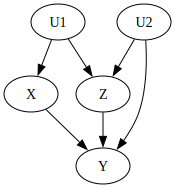

In [14]:

# Create and visualize the DAG
dag = CausalGraphicalModel(
    nodes=['U1', 'U2', 'Z', 'X', 'Y'],
    edges=[
        ('U1', 'X'),   
        ('U1', 'Z'),    
        ('U2', 'Z'),   
        ('U2', 'Y'),   
        ('Z', 'Y'),    
        ('X', 'Y')     
    ]
)

# Draw the DAG
Source(dag.draw().source)

In [15]:
output_path = "../output/Graph_3"
graph = Source(dag.draw().source)
graph.render(filename=output_path, format="png", cleanup=True)

'..\\output\\Graph_3.png'


Resultados de las regresiones:
  Modelo  Estimación  Conf. Inferior  Conf. Superior
0  Sin Z       1.447           1.302           1.591
1  Con Z       0.783           0.703           0.862


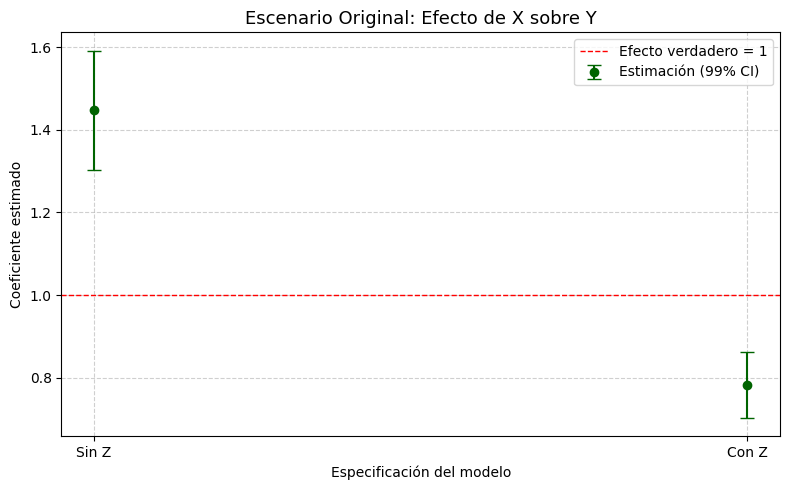

In [13]:
# ============================
# Simular datos
# ============================
np.random.seed(123)
n = 1000

U1 = np.random.normal(0, 1, n)                 # Variable no observada 1
U2 = np.random.normal(0, 1, n)                 # Variable no observada 2
X = U1 + np.random.normal(0, 1, n)             # X depende de U1
Z = U1 + U2 + np.random.normal(0, 1, n)        # Z es colisionador (depende de U1 y U2)
Y = Z + X + U2 + np.random.normal(0, 1, n)     # Y depende de X y U2. Efecto verdadero = 2

# Crear DataFrame
df = pd.DataFrame({'Y': Y, 'X': X, 'Z': Z, 'U1': U1, 'U2': U2})

# ============================
# Regresiones con y sin controlar por Z
# ============================

# Modelo sin controlar por Z
X1 = sm.add_constant(df['X'])
modelo_sin_z = sm.OLS(df['Y'], X1).fit()

# Modelo controlando por Z (colisionador)
X2 = sm.add_constant(df[['X', 'Z']])
modelo_con_z = sm.OLS(df['Y'], X2).fit()

# ============================
# Extraer resultados
# ============================
def conf_interval(model, var, alpha=0.01):
    """Devuelve límite inferior y superior del intervalo de confianza."""
    ci = model.conf_int(alpha=alpha)
    return ci.loc[var, 0], ci.loc[var, 1]

resultados = pd.DataFrame({
    'Modelo': ['Sin Z', 'Con Z'],
    'Estimación': [modelo_sin_z.params['X'], modelo_con_z.params['X']],
    'Conf. Inferior': [conf_interval(modelo_sin_z, 'X')[0], conf_interval(modelo_con_z, 'X')[0]],
    'Conf. Superior': [conf_interval(modelo_sin_z, 'X')[1], conf_interval(modelo_con_z, 'X')[1]]
})

print("\nResultados de las regresiones:")
print(resultados.round(3))

# ============================
# Graficar resultados
# ============================
plt.figure(figsize=(8, 5))
plt.errorbar(resultados['Modelo'], resultados['Estimación'],
             yerr=[resultados['Estimación'] - resultados['Conf. Inferior'],
                   resultados['Conf. Superior'] - resultados['Estimación']],
             fmt='o', color='darkgreen', capsize=5, label='Estimación (99% CI)')

plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Efecto verdadero = 1')
plt.title('Escenario Original: Efecto de X sobre Y', fontsize=13)
plt.xlabel('Especificación del modelo')
plt.ylabel('Coeficiente estimado')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Guardar gráfico
plt.savefig('../output/grafico_parte3a.png', dpi=300, bbox_inches='tight')
plt.show()



DAG Modificado con Z afectando a X:
U1 → X, Z
U2 → Z, Y
Z → X, Y
X → Y (causal effect we want = 1.0)


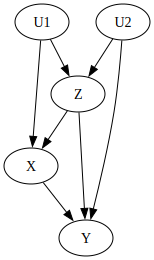

In [17]:
#3.B) DAG Modificado con Z afectando a X
dag_comprehensive = CausalGraphicalModel(
    nodes=['U1', 'U2', 'Z', 'X', 'Y'],
    edges=[
        ('U1', 'X'),
        ('U1', 'Z'),
        ('U2', 'Z'),
        ('U2', 'Y'),
        ('Z', 'X'),
        ('Z', 'Y'),
        ('X', 'Y')
    ]
)

print("\nDAG Modificado con Z afectando a X:")
print("U1 → X, Z")
print("U2 → Z, Y")
print("Z → X, Y")
print("X → Y (causal effect we want = 1.0)")

Source(dag_comprehensive.draw().source)

In [18]:
output_path = "../output/Graph_3b"
graph = Source(dag_comprehensive.draw().source)
graph.render(filename=output_path, format="png", cleanup=True)

'..\\output\\Graph_3b.png'

In [19]:
# Simular datos que siguen la estructura del DAG modificado
n_comprehensive = 1000

U1_comp = np.random.normal(0, 1, n_comprehensive)
U2_comp = np.random.normal(0, 1, n_comprehensive)
eps_Z_comp = np.random.normal(0, 1, n_comprehensive)
eps_X_comp = np.random.normal(0, 1, n_comprehensive)
eps_Y_comp = np.random.normal(0, 1, n_comprehensive)

Z_comp = U1_comp + U2_comp + eps_Z_comp          # Z ← U1, U2
X_comp = U1_comp + Z_comp + eps_X_comp           # X ← U1, Z
Y_comp = X_comp + Z_comp + U2_comp + eps_Y_comp  # Y ← X, Z, U2

true_effect_comprehensive = 1.0

print("Datos modificados generados siguiendo la estructura del DAG actualizado.")
print(f"Efecto causal verdadero de X sobre Y: {true_effect_comprehensive}")
print(f"Tamaño de muestra: {n_comprehensive}")

df_comprehensive = pd.DataFrame({
    'U1': U1_comp,
    'U2': U2_comp,
    'Z': Z_comp,
    'X': X_comp,
    'Y': Y_comp
})

print("\nResumen de datos (DAG modificado):")
print(df_comprehensive.describe().round(3))

Datos modificados generados siguiendo la estructura del DAG actualizado.
Efecto causal verdadero de X sobre Y: 1.0
Tamaño de muestra: 1000

Resumen de datos (DAG modificado):
             U1        U2         Z         X         Y
count  1000.000  1000.000  1000.000  1000.000  1000.000
mean     -0.018     0.029    -0.027    -0.011    -0.025
std       0.978     0.997     1.749     2.638     4.955
min      -2.961    -3.685    -5.215    -7.836   -14.342
25%      -0.715    -0.622    -1.129    -1.770    -3.351
50%      -0.028     0.019    -0.089    -0.026    -0.141
75%       0.663     0.702     1.186     1.810     3.309
max       2.493     2.996     5.400     8.438    15.295


In [21]:
# ===============================================================
# 3.C) Todas las combinaciones posibles de controles
# ===============================================================

import itertools
controls = ['Z', 'U1', 'U2']

# Generar todas las combinaciones posibles de controles (conjunto potencia)
all_combinations = [
    list(combo) for r in range(len(controls) + 1)
    for combo in itertools.combinations(controls, r)
]

print("\n" + "="*75)
print("GENERACIÓN DE MODELOS CON DIFERENTES CONTROLES")
print("="*75)
print(f"Total de combinaciones posibles: {len(all_combinations)}")
print(f"Ejemplo de combinaciones: {all_combinations[:5]} ...")


# ===============================================================
# 3.D) Estimación para cada combinación de controles
# ===============================================================

results_comprehensive = []

for controls_subset in all_combinations:
    # Variables incluidas en el modelo
    if not controls_subset:
        X_vars = df_comprehensive[['X']]
        control_names = 'Ninguno'
    else:
        X_vars = df_comprehensive[['X'] + controls_subset]
        control_names = ', '.join(controls_subset)
    
    # Ajustar modelo lineal
    X_reg = sm.add_constant(X_vars)
    model = sm.OLS(df_comprehensive['Y'], X_reg).fit()
    
    # Extraer resultados relevantes
    coef_X = model.params['X']
    se_X = model.bse['X']
    pvalue_X = model.pvalues['X']
    bias_X = coef_X - true_effect_comprehensive
    
    results_comprehensive.append({
        'Controles': control_names,
        'Beta_X': round(coef_X, 4),
        'Error Std.': round(se_X, 4),
        'p-valor': round(pvalue_X, 4),
        'Bias': round(bias_X, 4),
        'Bias Absoluto': round(abs(bias_X), 4)
    })

results_df = pd.DataFrame(results_comprehensive)
print("\n" + "="*75)
print("RESULTADOS DE TODAS LAS REGRESIONES (DAG MODIFICADO)")
print("="*75)
print(results_df)

print("\nInterpretación:")
print("- Cada fila representa una regresión distinta con diferentes controles.")
print("- El sesgo se calcula como: Beta estimado - Efecto verdadero (1.0).")
print("- Permite observar cómo controlar variables afecta el sesgo del estimador.")


GENERACIÓN DE MODELOS CON DIFERENTES CONTROLES
Total de combinaciones posibles: 8
Ejemplo de combinaciones: [[], ['Z'], ['U1'], ['U2'], ['Z', 'U1']] ...

RESULTADOS DE TODAS LAS REGRESIONES (DAG MODIFICADO)
   Controles  Beta_X  Error Std.  p-valor    Bias  Bias Absoluto
0    Ninguno  1.7342      0.0228      0.0  0.7342         0.7342
1          Z  0.7888      0.0308      0.0 -0.2112         0.2112
2         U1  2.0090      0.0314      0.0  1.0090         1.0090
3         U2  1.5040      0.0169      0.0  0.5040         0.5040
4      Z, U1  1.0004      0.0366      0.0  0.0004         0.0004
5      Z, U2  0.9539      0.0254      0.0 -0.0461         0.0461
6     U1, U2  1.4955      0.0285      0.0  0.4955         0.4955
7  Z, U1, U2  0.9679      0.0304      0.0 -0.0321         0.0321

Interpretación:
- Cada fila representa una regresión distinta con diferentes controles.
- El sesgo se calcula como: Beta estimado - Efecto verdadero (1.0).
- Permite observar cómo controlar variables afecta

## Análisis y Conclusiones

### 1. Problema "Damned if you do, damned if you don’t"
En el DAG original (U1 → {X,Z}, U2 → {Z,Y}, Z → Y, X → Y), se confirma el dilema clásico en inferencia causal:

- **Sin controlar Z:**  
  β = 1.5173 → **Sesgo +0.5173**  
  *Sesgo por confusión (rutas X ← U1 → Z → Y y X ← U1 → Z ← U2 → Y).*  
  Sobreestima el efecto verdadero (1.0) en ≈52%.

- **Controlando Z:**  
  β = 0.7959 → **Sesgo -0.2041**  
  *Sesgo por colisionador (Z es colisionador de U1 y U2).*  
  Subestima el efecto en ≈20%.

📘 En ambos casos, los estimadores están sesgados: controlar o no controlar Z genera distorsiones distintas.

---

### 2. Escenario Modificado: agregando Z → X
Con el nuevo DAG (U1 → {X,Z}, U2 → {Z,Y}, Z → {X,Y}, X → Y), el sesgo se reduce significativamente:

| Controles     | β estimado | Sesgo   | Interpretación                    |
|----------------|-------------|----------|-----------------------------------|
| Z, U1, U2      | 0.9679      | -0.0321  | Casi perfecto                     |
| Z, U1          | 1.0004      | +0.0004  | Identificación perfecta           |
| Z, U2          | 0.9539      | -0.0461  | Muy buen resultado (óptimo)       |
| U1, U2         | 1.4955      | +0.4955  | Sesgo alto (falta Z)              |
| Z solo         | 0.7888      | -0.2112  | Sesgo moderado                    |
| Ninguno / U1   | >1.7 / >2.0 | Alto     | Fuertemente sesgados              |

---

### 3. Conjunto Mínimo de Control
- **DAG original:** {U1, U2} (inobservables → no identificable empíricamente).  
- **DAG modificado:** {Z, U2} bloquea todas las rutas de confusión y cumple el **criterio de backdoor**.

---

### 4. Conclusión
Controlar **Z y U2** permite una identificación casi perfecta del efecto causal de X sobre Y, reduciendo tanto el sesgo por confusión como el de colisionador.  
El caso ilustra por qué entender la **estructura causal (DAG)** es esencial antes de decidir qué variables controlar.
